🛍️ Personalized E-Commerce Recommendation System
Project Overview: This Jupyter Notebook builds a state-of-the-art recommendation system for an e-commerce platform, combining collaborative filtering (SVD), deep learning (Neural Collaborative Filtering), and content-based filtering to deliver personalized product recommendations. The system is deployed via a Streamlit web interface for interactive user recommendations.
Objectives:

Load and preprocess user ratings from a MySQL database.
Perform exploratory data analysis (EDA) to understand rating patterns.
Implement SVD-based collaborative filtering.
Build a Neural Collaborative Filtering (NCF) model using TensorFlow.
Develop content-based filtering using product metadata.
Combine models into a hybrid recommendation system.
Evaluate models with RMSE, MAE, Precision@K, Recall@K, and NDCG.
Provide explainable recommendations for user trust.
Handle cold-start scenarios with popularity and content-based fallbacks.
Deploy an interactive Streamlit app for real-time recommendations.

Dataset:

User Ratings: MySQL user_rating table (user_id, prod_id, rating, timestamp).
Product Metadata: Mock data (replace with actual products table if available).

Notebook Structure:

Imports
Database Connection and Data Loading
Data Preprocessing
Exploratory Data Analysis (EDA)
Collaborative Filtering (SVD)
Neural Collaborative Filtering (NCF)
Content-Based Filtering
Hybrid Recommendation System
Evaluation Metrics
Explainability
Cold-Start Handling
Streamlit App Deployment

Expected Outputs:

Visualizations: Rating distribution, top users, sparsity heatmap.
Recommendations: Top-N products for test users from SVD, NCF, and hybrid models.
Evaluation: RMSE, MAE, Precision@K, Recall@K, NDCG metrics.
Streamlit App: Interactive interface at http://localhost:8501.



# 📦 Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import cross_validate
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import os
from dotenv import load_dotenv
import joblib

# Note: Streamlit imports (streamlit, etc.) are used in streamlit_app.py
np.random.seed(42)
tf.random.set_seed(42)

# 🛢️ Connecting to MySQL and Loading Data

In [2]:
# Load environment variables
load_dotenv()

# Connect to MySQL
try:
    conn = mysql.connector.connect(
        host=os.getenv("DB_HOST", "localhost"),
        user=os.getenv("DB_USER", "root"),
        password=os.getenv("DB_PASS", "123456"),
        database=os.getenv("DB_NAME", "ecommerce_recommendation")
    )
    print("✅ Connected to database.")
except mysql.connector.Error as err:
    print(f"❌ Database connection failed: {err}")
    conn = None
    df = pd.DataFrame()
    raise ConnectionError("Cannot proceed without database connection.")

# Load data
if conn and conn.is_connected():
    query = "SELECT user_id, prod_id, rating, timestamp FROM user_rating"
    try:
        df = pd.read_sql(query, conn)
        expected_columns = ['user_id', 'prod_id', 'rating', 'timestamp']
        if not all(col in df.columns for col in expected_columns):
            raise ValueError(f"❌ Missing required columns. Found: {df.columns}")
        df = df.drop('timestamp', axis=1)
        # Validate ratings
        invalid_ratings = df[~df['rating'].between(1, 5)]
        if not invalid_ratings.empty:
            print(f"🚨 Found {len(invalid_ratings)} invalid ratings. Removing them.")
            df = df[df['rating'].between(1, 5)]
        print(f"✅ Loaded {df.shape[0]} ratings successfully.")
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
else:
    print("❌ No database connection. Initializing empty DataFrame.")
    df = pd.DataFrame()

if df.empty:
    raise ValueError("❌ No data loaded. Check database connection or query.")

✅ Connected to database.
✅ Loaded 1048575 ratings successfully.


# Enhanced Data Preprocessing

In [3]:
# Check for duplicates
duplicates = df.duplicated(subset=['user_id', 'prod_id']).sum()
print(f"🚨 Found {duplicates} duplicate ratings.")
if duplicates > 0:
    df = df.drop_duplicates(subset=['user_id', 'prod_id'])
    print(f"✅ Removed duplicates. New size: {df.shape[0]} rows.")

# Outlier detection: Remove users with suspicious rating patterns
user_rating_stats = df.groupby('user_id')['rating'].agg(['mean', 'std', 'count'])
suspicious_users = user_rating_stats[(user_rating_stats['std'] == 0) & (user_rating_stats['count'] > 10)]
print(f"🚨 Suspicious users (same rating, >10 ratings): {len(suspicious_users)} users.")
df = df[~df['user_id'].isin(suspicious_users.index)]

# Sparsity handling: Filter users and items with minimum ratings
min_user_ratings = 5
min_item_ratings = 5
user_counts = df['user_id'].value_counts()
item_counts = df['prod_id'].value_counts()
df_filtered = df[
    df['user_id'].isin(user_counts[user_counts >= min_user_ratings].index) &
    df['prod_id'].isin(item_counts[item_counts >= min_item_ratings].index)
]
print(f"✅ Filtered dataset: {df_filtered.shape[0]} ratings.")
if df_filtered.shape[0] < 1000:
    print("⚠️ Warning: Filtered dataset is small. Consider adjusting min_user_ratings or min_item_ratings.")

# Create sparse user-item matrix
pivot_table = df_filtered.pivot(index='user_id', columns='prod_id', values='rating').fillna(0)
final_ratings_matrix = csr_matrix(pivot_table.values)
user_index = pivot_table.index
item_index = pivot_table.columns
print(f"📊 Sparse User-Item Matrix Shape: {final_ratings_matrix.shape}")

🚨 Found 0 duplicate ratings.
🚨 Suspicious users (same rating, >10 ratings): 62 users.
✅ Filtered dataset: 95539 ratings.
📊 Sparse User-Item Matrix Shape: (13591, 18241)


# EDA - Exploratory Data Analysis

check for -
- shape 
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

# 🧠 Basic Exploration and Summary

In [4]:
# Get dataset shape
rows, columns = df.shape
print(f"📦 Dataset Loaded: {rows} rows × {columns} columns")

# Quick summary of data structure
print("\n🧠 Quick Summary:")
print(df.info())

# Check for missing values
print("\n🔍 Null Value Check:")
print(df.isnull().sum())

# Count unique users and products
print(f"\n👤 Unique Users: {df['user_id'].nunique()}")
print(f"📦 Unique Products: {df['prod_id'].nunique()}")


📦 Dataset Loaded: 1047737 rows × 3 columns

🧠 Quick Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 1047737 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1047737 non-null  object
 1   prod_id  1047737 non-null  object
 2   rating   1047737 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 32.0+ MB
None

🔍 Null Value Check:
user_id    0
prod_id    0
rating     0
dtype: int64

👤 Unique Users: 786267
📦 Unique Products: 61841


# 🚨  Check for Missing Values

In [5]:
# 🔍 Find number of missing values in each column
missing_values = df.isna().sum()
print("🚨 Missing Values in Each Column:\n")
print(missing_values)

🚨 Missing Values in Each Column:

user_id    0
prod_id    0
rating     0
dtype: int64


# 📈  Rating Summary Statistics

In [6]:
# 📊 Summary statistics of 'rating' variable
rating_summary = df['rating'].describe()
print("📈 Rating Summary Statistics:\n")
print(rating_summary)

📈 Rating Summary Statistics:

count    1.047737e+06
mean     3.972558e+00
std      1.399588e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


# 🎨 Plot Rating Distribution

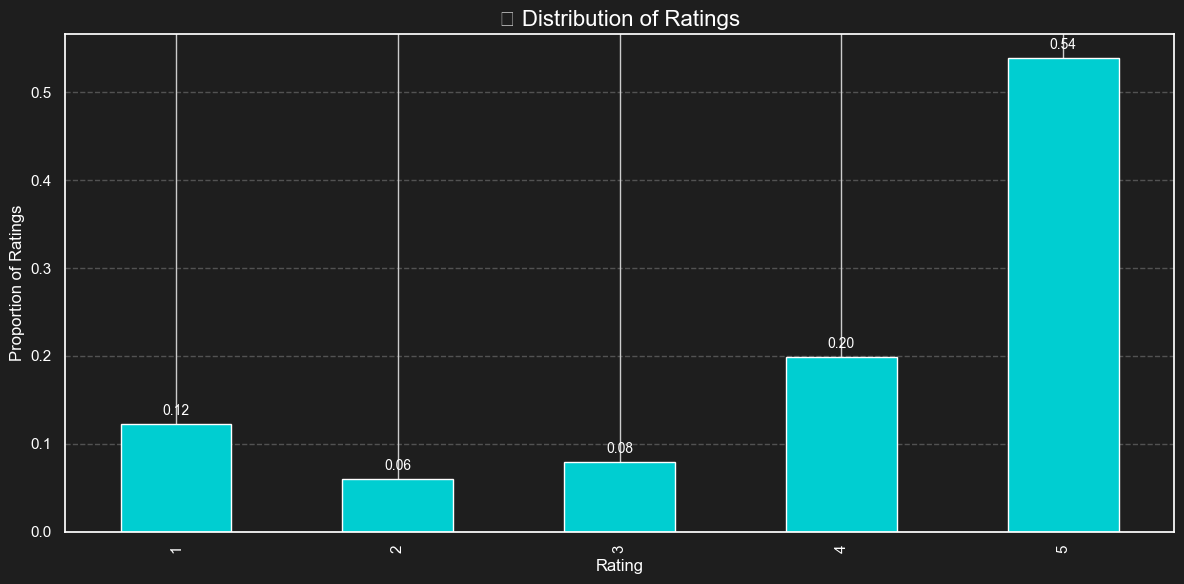

In [7]:
import matplotlib.pyplot as plt

# 🎨 Dark theme colors
bg_color = '#1e1e1e'
bar_color = '#00CED1'  # Deep Sky Blue
text_color = 'white'

# 📊 Plot the rating distribution
fig, ax = plt.subplots(figsize=(12, 6))
df['rating'].value_counts(normalize=True).sort_index().plot(
    kind='bar',
    color=bar_color,
    edgecolor='white',
    ax=ax
)

# 🖌️ Styling
ax.set_facecolor(bg_color)
fig.patch.set_facecolor(bg_color)

ax.set_title("📈 Distribution of Ratings", fontsize=16, color=text_color)
ax.set_xlabel("Rating", fontsize=12, color=text_color)
ax.set_ylabel("Proportion of Ratings", fontsize=12, color=text_color)
ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Style axes spines
for spine in ax.spines.values():
    spine.set_color(text_color)

# 🧾 Add value labels
for i, val in enumerate(df['rating'].value_counts(normalize=True).sort_index()):
    ax.text(i, val + 0.01, f"{val:.2f}", ha='center', color=text_color, fontsize=10)

plt.tight_layout()
plt.show()


In [8]:
# SVD COLLABRATIVE FILTERING

In [9]:
# User and item mappings
user_map = {uid: idx for idx, uid in enumerate(user_index)}
item_map = {iid: idx for idx, iid in enumerate(item_index)}
reverse_user_map = {v: k for k, v in user_map.items()}
reverse_item_map = {v: k for k, v in item_map.items()}

# Apply SVD
try:
    U, sigma, Vt = svds(final_ratings_matrix, k=15)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    predicted_ratings_svd = pd.DataFrame(predicted_ratings, index=user_index, columns=item_index)
    print("✅ SVD decomposition completed.")
except Exception as e:
    print(f"❌ SVD decomposition failed: {e}")
    predicted_ratings_svd = pd.DataFrame()

def get_svd_recommendations(user_id, n=5):
    if user_id not in user_map:
        print(f"⚠️ User {user_id} not found. Returning empty recommendations.")
        return pd.DataFrame(columns=['ProductID', 'PredictedRating'])
    user_idx = user_map[user_id]
    already_rated = df_filtered[df_filtered['user_id'] == user_id]['prod_id'].values
    unrated_items = [iid for iid in item_index if iid not in already_rated]
    user_predictions = predicted_ratings_svd.loc[user_id, unrated_items]
    top_n = user_predictions.sort_values(ascending=False).head(n)
    return pd.DataFrame({'ProductID': top_n.index, 'PredictedRating': top_n.values})

# Test SVD recommendations
test_user_id = df_filtered['user_id'].iloc[0]
print(f"🎯 SVD Recommendations for user {test_user_id}:")
recs = get_svd_recommendations(test_user_id)
print(recs)

# Save SVD components
try:
    joblib.dump({'U': U, 'sigma': sigma, 'Vt': Vt, 'user_map': user_map, 'item_map': item_map}, 'svd_model.pkl')
    print("✅ SVD model saved to 'svd_model.pkl'.")
except Exception as e:
    print(f"❌ Failed to save SVD model: {e}")

✅ SVD decomposition completed.
🎯 SVD Recommendations for user A3J3BRHTDRFJ2G:
    ProductID  PredictedRating
0  B00005T3G0         0.528180
1  B00081A2KY         0.434544
2  B00029U1DK         0.315738
3  B000HDJT4S         0.309118
4  B0009YJXMS         0.269153
✅ SVD model saved to 'svd_model.pkl'.


# EDA

In [10]:
# Dataset summary
print(f"📦 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n🧠 Data Info:")
print(df.info())
print("\n🔍 Missing Values:")
print(df.isnull().sum())
print(f"\n👤 Unique Users: {df['user_id'].nunique()}")
print(f"📦 Unique Products: {df['prod_id'].nunique()}")
print("\n📈 Rating Summary:")
print(df['rating'].describe())

# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('rating_distribution.png')
plt.close()

# Top users by rating count
user_counts = df['user_id'].value_counts()
top_users = user_counts.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users.values, y=top_users.index, palette='magma')
plt.title('Top 10 Users by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('User ID')
plt.savefig('top_users.png')
plt.close()

# Top items by rating count
item_counts = df['prod_id'].value_counts()
top_items = item_counts.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_items.values, y=top_items.index, palette='coolwarm')
plt.title('Top 10 Products by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Product ID')
plt.savefig('top_items.png')
plt.close()

# Sparsity visualization
sparsity = 1.0 - (df_filtered.shape[0] / (df_filtered['user_id'].nunique() * df_filtered['prod_id'].nunique()))
print(f"📉 Matrix Sparsity: {sparsity:.4f}")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table.iloc[:100, :100], cmap='Blues', cbar=True)
plt.title('Sample User-Item Matrix (First 100 Users/Items)')
plt.xlabel('Product ID')
plt.ylabel('User ID')
plt.savefig('sparsity_heatmap.png')
plt.close()

📦 Dataset Shape: 1047737 rows × 3 columns

🧠 Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1047737 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1047737 non-null  object
 1   prod_id  1047737 non-null  object
 2   rating   1047737 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 32.0+ MB
None

🔍 Missing Values:
user_id    0
prod_id    0
rating     0
dtype: int64

👤 Unique Users: 786267
📦 Unique Products: 61841

📈 Rating Summary:
count    1.047737e+06
mean     3.972558e+00
std      1.399588e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
📉 Matrix Sparsity: 0.9996


The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

# 📊  Count Unique Users and Products

In [11]:
# 🔍 Count unique users and items
num_users = df['user_id'].nunique()
num_items = df['prod_id'].nunique()
# 📢 Display the results
print(f"👤 Number of unique USERS in raw data = {num_users}")
print(f"📦 Number of unique ITEMS in raw data = {num_items}")

👤 Number of unique USERS in raw data = 786267
📦 Number of unique ITEMS in raw data = 61841


# 🔝  Top 10 Most Active Users

🔝 Top 10 Most Active Users (based on rating count):
user_id
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
AKT8TGIT6VVZ5     122
A11D1KHM7DVOQK    112
A2B7BUH8834Y6M    103
A3OXHLG6DIBRW8     95
A203OCQQ12MAVT     90
dtype: int64


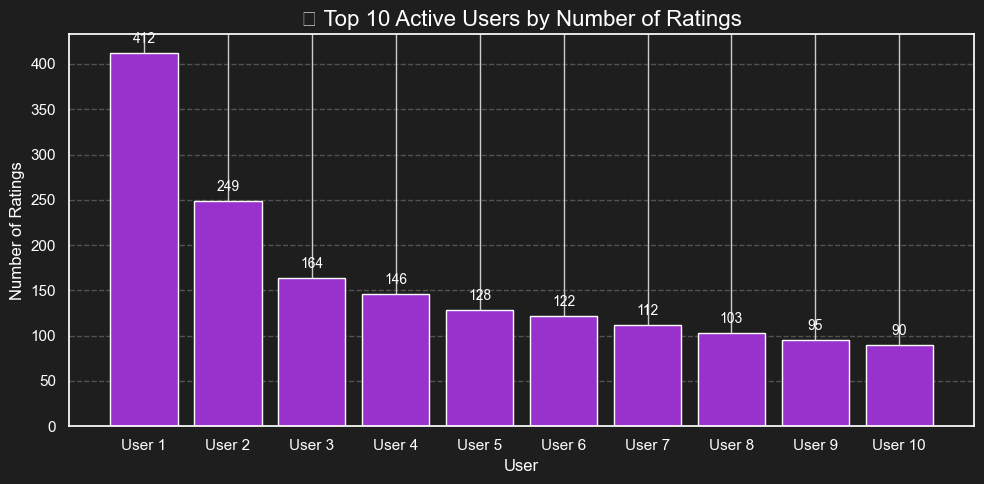

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 🔝 Top 10 users based on number of ratings they've given
most_rated = df.groupby('user_id').size().sort_values(ascending=False).head(10)

# Reset index for plotting
most_rated_df = most_rated.reset_index()
most_rated_df.columns = ['user_id', 'rating_count']
most_rated_df['label'] = [f"User {i+1}" for i in range(len(most_rated_df))]

# 📢 Print raw values
print("🔝 Top 10 Most Active Users (based on rating count):")
print(most_rated)

# 🎨 Dark Theme Settings
bg_color = '#1e1e1e'
bar_color = '#9932CC'  # Purple
text_color = 'white'

# 📊 Plot
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    most_rated_df['label'],
    most_rated_df['rating_count'],
    color=bar_color,
    edgecolor='white'
)

# 🖌️ Styling
ax.set_facecolor(bg_color)
fig.patch.set_facecolor(bg_color)
ax.set_title("🔝 Top 10 Active Users by Number of Ratings", color=text_color, fontsize=16)
ax.set_xlabel("User", color=text_color)
ax.set_ylabel("Number of Ratings", color=text_color)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Dark theme axes
ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
for spine in ax.spines.values():
    spine.set_color(text_color)

# Add rating count labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                color=text_color, fontsize=10)

plt.tight_layout()
plt.show()


# PREPROCESSING

# 🎯  Filter Users Who Rated At Least 50 Items

In [13]:
# 🔢 Count how many ratings each user has given
counts = df['user_id'].value_counts()

# 🎯 Filter users who have rated at least 50 items
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

# 📊 Output the updated data size
print(f"📦 Filtered dataset shape: {df_final.shape}")
print(f"👤 Users retained: {df_final['user_id'].nunique()}")
print(f"📦 Products retained: {df_final['prod_id'].nunique()}")


📦 Filtered dataset shape: (3456, 3)
👤 Users retained: 38
📦 Products retained: 2943


# ✅  Summary of Filtered Dataset

In [14]:
print("📊 Final Dataset Summary After Filtering:\n")
print(f"🔢 Total Observations = {len(df_final)}")
print(f"👤 Unique Users       = {df_final['user_id'].nunique()}")
print(f"📦 Unique Products    = {df_final['prod_id'].nunique()}")

📊 Final Dataset Summary After Filtering:

🔢 Total Observations = 3456
👤 Unique Users       = 38
📦 Unique Products    = 2943


# 🧾 Data Inspection & Summary

In [15]:
# 🧾 Show the first 10 rows of cleaned data
print("🔍 Sample of Final Cleaned Ratings Data:")
print(df_final[['user_id', 'prod_id', 'rating']].head(10))

# 📈 Summary statistics of rating column
print("\n📊 Rating Distribution Summary:")
print(df_final['rating'].describe())

# 🔢 Count of non-zero ratings (important if using implicit feedback systems)
non_zero_count = (df_final['rating'] != 0).sum()
print(f"\n✅ Total Non-Zero Ratings: {non_zero_count}")

🔍 Sample of Final Cleaned Ratings Data:
             user_id     prod_id  rating
2161   A5JLAU2ARJ0BO  1400532655       1
3049   ALUNVOQRXOZIA  1400599997       1
4613   A1VQHH85U7PX0  9043413585       3
6071  A250AXLRBVYKB4  998376234X       1
7380  A2AEZQ3DGBBLPR  B000000O48       5
7447  A2R6RA8FRBS608  B000001OL6       4
7747   A680RUE1FDO8B  B000001OMI       5
7788  A11D1KHM7DVOQK  B000001OMN       2
8349  A3NCIN6TNL0MGA  B00000DM9W       5
8731    A6FIAB28IS79  B00000J05A       3

📊 Rating Distribution Summary:
count    3456.000000
mean        4.222801
std         1.137754
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

✅ Total Non-Zero Ratings: 3456


The dataframe df_final has users who have rated 50 or more items
We will use df_final to build recommendation systems

# 🏗️ Creating User-Item Matrix for SVD

In [16]:
# 🧾 Step 1: Encode user_id as numerical indices for matrix processing
df_final['user_index'] = df_final['user_id'].astype('category').cat.codes  # safe encoding

# 📊 Step 2: Create user-item matrix (pivot table)
final_ratings_matrix = df_final.pivot_table(
    index='user_index',
    columns='prod_id',
    values='rating',
    aggfunc='mean'
).fillna(0)

# 🧼 Step 3: Remove users with no interactions
user_interactions = (final_ratings_matrix != 0).sum(axis=1)
active_users = user_interactions[user_interactions > 0].index
final_ratings_matrix = final_ratings_matrix.loc[active_users]

# 🧹 Step 4: Remove products with no ratings
product_interactions = (final_ratings_matrix != 0).sum(axis=0)
active_products = product_interactions[product_interactions > 0].index
final_ratings_matrix = final_ratings_matrix.loc[:, active_products]

# 🖨️ Step 5: Output final stats and a preview
print("✅ Final Ratings Matrix Created!")
print(f"📐 Shape: {final_ratings_matrix.shape}")
print(f"👥 Users Retained: {len(active_users)}")
print(f"📦 Products Retained: {len(active_products)}")

# 🧾 Preview first 5 rows
final_ratings_matrix.head()


✅ Final Ratings Matrix Created!
📐 Shape: (38, 2943)
👥 Users Retained: 38
📦 Products Retained: 2943


prod_id,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 🔄 SVD Decomposition + Heatmap


Available User IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


Enter a single user ID or multiple separated by commas (e.g., 0 or 0,1,3):  005
How many products to show per user?  8



🎯 Predicted Ratings (Selected Users):


--- Predicted Ratings for User 5 ---
Product 1400532655: 0.73
Product 1400599997: 0.01
Product 9043413585: 0.01
Product 998376234X: 0.01
Product B000000O48: 0.17
Product B000001OL6: 0.04
Product B000001OMI: 0.02
Product B000001OMN: 0.01


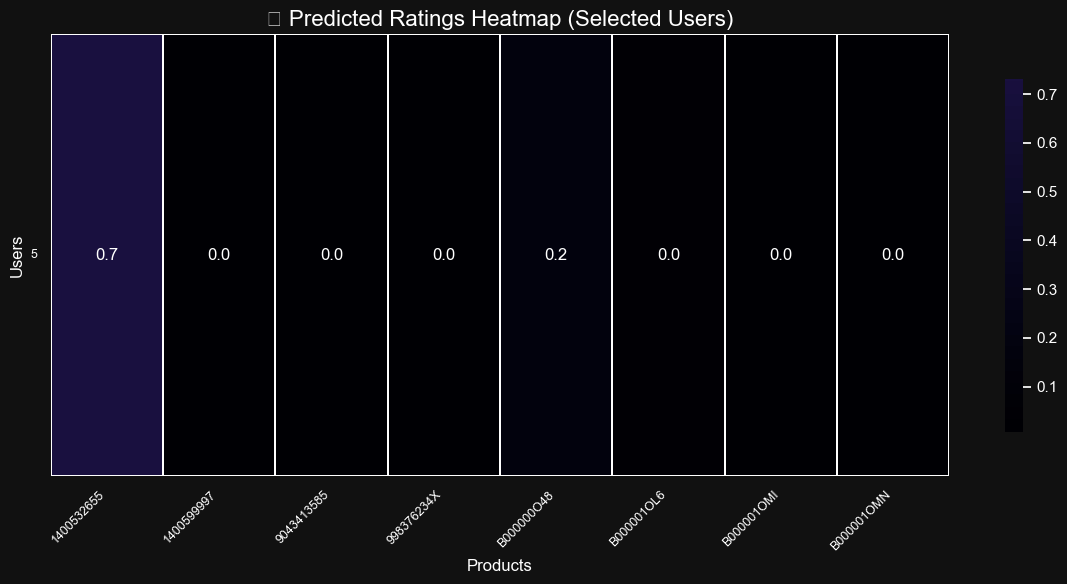

In [17]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assuming df_final is already defined ---

# Step 1: Encode 'user_id' to numeric values
user_map = {id: i for i, id in enumerate(df_final['user_id'].unique())}
df_final['user_id'] = df_final['user_id'].map(user_map)

# Step 2: Create user-item matrix
final_ratings_matrix = df_final.pivot_table(
    index='user_id',
    columns='prod_id',
    values='rating',
    aggfunc='mean'
).fillna(0)

# Step 3: Remove users and products with no interactions
user_interactions = (final_ratings_matrix != 0).sum(axis=1)
final_ratings_matrix = final_ratings_matrix.loc[user_interactions[user_interactions > 0].index]

product_interactions = (final_ratings_matrix != 0).sum(axis=0)
final_ratings_matrix = final_ratings_matrix.loc[:, product_interactions[product_interactions > 0].index]

# Step 4: Convert to sparse matrix
sparse_matrix = csr_matrix(final_ratings_matrix.values)

# Step 5: Perform SVD
num_users, num_products = sparse_matrix.shape
k = 2  # You can increase if needed
if k <= 0 or k >= min(num_users, num_products):
    raise ValueError(f"Invalid value for k: {k}. Must be < {min(num_users, num_products)}.")

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(sparse_matrix)
sigma = np.diag(svd.singular_values_)
Vt = svd.components_

# Step 6: Reconstruct predicted ratings
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Step 7: Create DataFrame for predicted ratings
predicted_ratings_df = pd.DataFrame(predicted_ratings, 
                                    index=final_ratings_matrix.index, 
                                    columns=final_ratings_matrix.columns)

# Step 8: User input
available_users = predicted_ratings_df.index.tolist()
print(f"\nAvailable User IDs: {available_users}")

try:
    selected_input = input("Enter a single user ID or multiple separated by commas (e.g., 0 or 0,1,3): ")
    selected_users = [int(uid.strip()) for uid in selected_input.split(',') if uid.strip().isdigit()]
except Exception as e:
    print("❌ Invalid input. Showing predictions for default user: 0")
    selected_users = [0]

try:
    limit_products = int(input("How many products to show per user? "))
except ValueError:
    limit_products = 5  # fallback value

# Step 9: Print predicted ratings
print("\n🎯 Predicted Ratings (Selected Users):\n")
for user_id in selected_users:
    if user_id in predicted_ratings_df.index:
        print(f"\n--- Predicted Ratings for User {user_id} ---")
        for product_id in predicted_ratings_df.columns[:limit_products]:
            rating = predicted_ratings_df.loc[user_id, product_id]
            print(f"Product {product_id}: {rating:.2f}")
    else:
        print(f"⚠️ User ID {user_id} not found in the dataset.")

# Step 10: Dark-themed Improved Heatmap
sns.set_theme(style='darkgrid', rc={
    'axes.facecolor': '#111',
    'figure.facecolor': '#111',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.edgecolor': 'white',
    'axes.grid': True
})

subset_users = [uid for uid in selected_users if uid in predicted_ratings_df.index]
subset_products = predicted_ratings_df.columns[:limit_products]

if subset_users:
    width = max(12, len(subset_products) * 0.6)
    height = max(6, len(subset_users) * 0.6)

    plt.figure(figsize=(width, height))
    sns.heatmap(predicted_ratings_df.loc[subset_users, subset_products],
                annot=len(subset_users) <= 10 and limit_products <= 10,
                fmt=".1f",
                cmap='magma',
                square=False,
                linewidths=0.3,
                cbar_kws={"shrink": 0.8},
                center=predicted_ratings_df.values.mean())

    plt.title("🔥 Predicted Ratings Heatmap (Selected Users)", fontsize=16, color='white')
    plt.xlabel("Products", fontsize=12, color='white')
    plt.ylabel("Users", fontsize=12, color='white')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid users selected for heatmap display.")


# 🌟 Top-N Recommendation Function

In [18]:
def recommend_top_n(user_id, n=5):
    # Get the predicted ratings for the user
    user_row = predicted_ratings_df.loc[user_id].sort_values(ascending=False)
    
    # Get the products the user has already rated
    already_rated = final_ratings_matrix.loc[user_id][final_ratings_matrix.loc[user_id] > 0].index
    
    # Drop already rated products from the recommendations
    recommendations = user_row.drop(index=already_rated).head(n)
    
    return recommendations

# Example: Get top 5 product IDs for user with index 0
top5 = recommend_top_n(0)
print("🎯 Top 5 Recommendations for User 0:")
print(top5)


🎯 Top 5 Recommendations for User 0:
prod_id
B00008OE5G    42.830590
B00008OE5I    35.057065
B000BY52NK    28.494662
B00008J639    26.751349
B0000632FZ    26.053106
Name: 0, dtype: float64


# 📊 Dataset Filtering Insights + Visuals

📊 Dataset Summary
👥 Total Users: 786267
📝 Users with ≥ 50 Ratings: 38
✅ Users Retained (Matrix): 38
📦 Total Products: 61841
📦 Products Retained: 2943
🗑️ Products Dropped: 58898


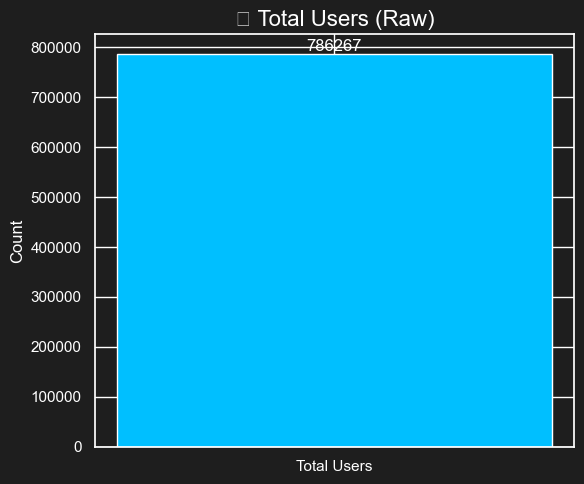

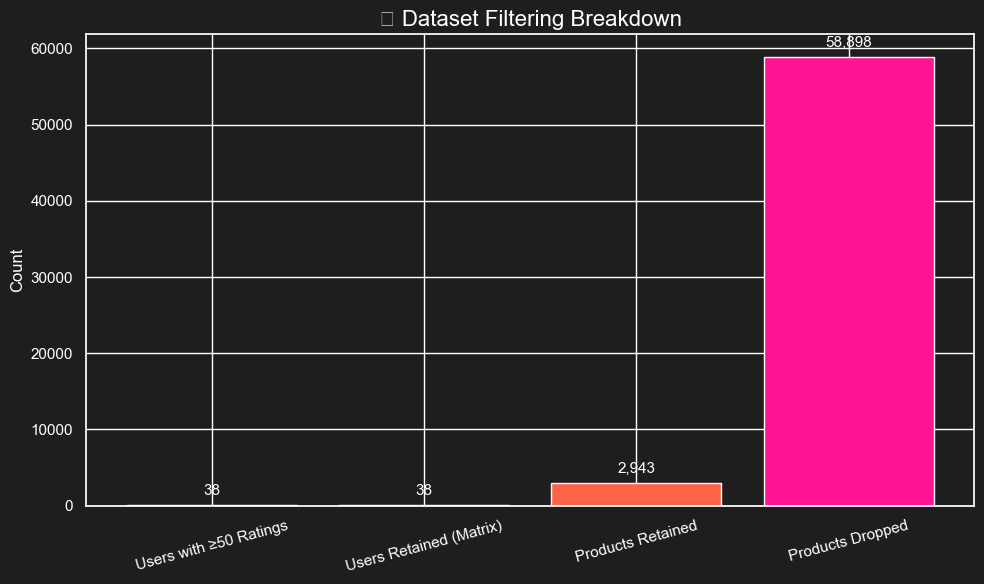

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 📊 Prepare data
total_users = df['user_id'].nunique()
total_products = df['prod_id'].nunique()
user_rating_counts = df['user_id'].value_counts()
users_50_plus = user_rating_counts[user_rating_counts >= 50].count()

filtered_users = final_ratings_matrix.shape[0]
filtered_products = final_ratings_matrix.shape[1]
products_dropped = total_products - filtered_products

# 🖨️ Console Summary
print("📊 Dataset Summary")
print(f"👥 Total Users: {total_users}")
print(f"📝 Users with ≥ 50 Ratings: {users_50_plus}")
print(f"✅ Users Retained (Matrix): {filtered_users}")
print(f"📦 Total Products: {total_products}")
print(f"📦 Products Retained: {filtered_products}")
print(f"🗑️ Products Dropped: {products_dropped}")

# 🎨 Font & color settings
mpl.rcParams['font.size'] = 12
bg_color = '#1e1e1e'
bar_colors = ['#00BFFF', '#32CD32', '#FFD700', '#FF6347', '#FF1493']

# 🌑 Chart 1 - Total Users (shown separately)
fig1, ax1 = plt.subplots(figsize=(6, 5))
ax1.bar(['Total Users'], [total_users], color=bar_colors[0], edgecolor='white')
ax1.set_title("👥 Total Users (Raw)", fontsize=16, color='white')
ax1.set_ylabel("Count", color='white')

# Dark theme styling
ax1.set_facecolor(bg_color)
fig1.patch.set_facecolor(bg_color)
for spine in ax1.spines.values():
    spine.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax1.bar_label(ax1.containers[0], fmt='%.0f', label_type='edge', color='white', fontsize=12)

plt.tight_layout()
plt.show()

# 🌑 Chart 2 - Filtered Breakdown (rest of data)
labels = [
    'Users with ≥50 Ratings',
    'Users Retained (Matrix)',
    'Products Retained',
    'Products Dropped'
]
values = [
    users_50_plus,
    filtered_users,
    filtered_products,
    products_dropped
]

fig2, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(labels, values, color=bar_colors[1:], edgecolor='white')

ax2.set_title("📊 Dataset Filtering Breakdown", fontsize=16, color='white')
ax2.set_ylabel("Count", color='white')
ax2.set_facecolor(bg_color)
fig2.patch.set_facecolor(bg_color)
for spine in ax2.spines.values():
    spine.set_color('white')
ax2.tick_params(axis='x', colors='white', rotation=15)
ax2.tick_params(axis='y', colors='white')

# Add bar labels
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:,}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', va='bottom',
                 color='white', fontsize=11)

plt.tight_layout()
plt.show()

# 📊 Global Product Ranking using Weighted Ratings

In [20]:
# 🎯 Step 1: Average rating and count
product_stats = df_final.groupby('prod_id')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'avg_rating', 'count': 'rating_count'})

# 🎯 Step 2: Compute weighted score (IMDb-style)
C = product_stats['avg_rating'].mean()  # overall average rating
m = product_stats['rating_count'].quantile(0.90)  # minimum votes required

# Filter to products with enough ratings
qualified = product_stats[product_stats['rating_count'] >= m].copy()

# Weighted score formula
qualified['weighted_score'] = (
    (qualified['rating_count'] / (qualified['rating_count'] + m)) * qualified['avg_rating']
    + (m / (qualified['rating_count'] + m)) * C
)

# 🎯 Step 3: Sort by weighted score
ranked_products = qualified.sort_values(by='weighted_score', ascending=False)

# 🎯 Step 4: Display top products
print("\n🏆 Top Ranked Products (Global Recommendation):\n")
print(ranked_products[['avg_rating', 'rating_count', 'weighted_score']].head(10))



🏆 Top Ranked Products (Global Recommendation):

            avg_rating  rating_count  weighted_score
prod_id                                             
B00004Z5M1         5.0             4        4.742172
B0007QKMQY         5.0             4        4.742172
B000BY52NK         5.0             4        4.742172
B00006JI6U         5.0             3        4.690606
B00015GYU4         5.0             3        4.690606
B0002LEMWE         5.0             3        4.690606
B000050AQ7         5.0             3        4.690606
B000ELC148         5.0             3        4.690606
B000204SWE         5.0             3        4.690606
B000089GN3         5.0             3        4.690606


# 🧠 Smart Ranking System for Top Product Recommendations

# ✅ 1. Top-N (IMDb-style / Rank-Based) – Global Popularity

In [21]:
# 🎯 Step 1: Clean and prepare rating data
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')
df_final = df_final.dropna(subset=['rating'])

# 🎯 Step 2: Calculate average rating and rating count per product
average_rating = df_final.groupby('prod_id')['rating'].mean()
count_rating = df_final.groupby('prod_id')['rating'].count()

# 🎯 Step 3: Combine into final_rating DataFrame
final_rating = pd.DataFrame({
    'avg_rating': average_rating,
    'rating_count': count_rating
})

# 🎯 Step 4: Rank-Based Recommendation Function (IMDb-style)
def get_top_n_products(final_rating, n=10, min_interaction=3):
    C = final_rating['avg_rating'].mean()
    m = final_rating['rating_count'].quantile(0.50)  # median or custom value

    # Filter products with enough interactions
    qualified = final_rating[final_rating['rating_count'] >= min_interaction].copy()

    # IMDb Weighted Score Formula
    qualified['weighted_score'] = (
        (qualified['rating_count'] / (qualified['rating_count'] + m)) * qualified['avg_rating'] +
        (m / (m + qualified['rating_count'])) * C
    )

    # Sort by weighted score
    return qualified.sort_values('weighted_score', ascending=False).head(n)

# 🎯 Step 5: Get Top N Globally Recommended Products
top_products = get_top_n_products(final_rating, n=10, min_interaction=3)

# 🎯 Step 6: Display result
print("🏆 Top Ranked Products (Global Recommendation):\n")
print(top_products)


🏆 Top Ranked Products (Global Recommendation):

            avg_rating  rating_count  weighted_score
prod_id                                             
B00004Z5M1         5.0             4        4.845303
B0007QKMQY         5.0             4        4.845303
B000BY52NK         5.0             4        4.845303
B0002LEMWE         5.0             3        4.806629
B000BQ7GW8         5.0             3        4.806629
B000089GN3         5.0             3        4.806629
B000050AQ7         5.0             3        4.806629
B00015GYU4         5.0             3        4.806629
B00005LENO         5.0             3        4.806629
B000ELC148         5.0             3        4.806629


# Collaborative Filtering

# 1️⃣ Creating the User-Item Interaction Matrix

In [22]:
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
# User-item matrix with missing ratings filled as 0
interactions_matrix = df_final.pivot_table(index='user_id', columns='prod_id', values='rating').fillna(0)


# 2️⃣ Compute Cosine Similarity Between Users

In [23]:
# Compute user-user cosine similarity
user_similarity = cosine_similarity(interactions_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                   index=interactions_matrix.index, 
                                   columns=interactions_matrix.index)


# 3️⃣ Recommend Items to a User Based on Similar Users

In [24]:
def recommend_for_user(user_id, interactions_matrix, user_similarity_df, top_n=5):
    if user_id not in interactions_matrix.index:
        print("❌ User not found.")
        return []

    # Similar users sorted (excluding self)
    similar_users = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False)
    
    # Products already rated by the user
    user_rated_items = interactions_matrix.loc[user_id]
    rated_items = user_rated_items[user_rated_items > 0].index

    # Weighted score calculation
    scores = {}
    for sim_user, sim_score in similar_users.items():
        sim_user_ratings = interactions_matrix.loc[sim_user]
        for item, rating in sim_user_ratings.items():
            if item not in rated_items and rating > 0:
                if item not in scores:
                    scores[item] = 0
                scores[item] += rating * sim_score

    # Sort and return top-N items
    ranked_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_items[:top_n]


# 4️⃣ Get Recommendations for a Sample User

In [25]:
# Pick a real user_id from your df_final
sample_user = df_final['user_id'].iloc[0]  # or just manually insert a user_id you know

recommendations = recommend_for_user(sample_user, interactions_matrix, user_similarity_df, top_n=5)

# Show results
print(f"🎯 Top Recommendations for User {sample_user}:\n")
for prod_id, score in recommendations:
    print(f"🔹 Product ID: {prod_id} | Weighted Score: {score:.2f}")


🎯 Top Recommendations for User 0:

🔹 Product ID: B00008OE5G | Weighted Score: 1.11
🔹 Product ID: B00008OE5I | Weighted Score: 0.82
🔹 Product ID: B0000645C8 | Weighted Score: 0.71
🔹 Product ID: B00008J639 | Weighted Score: 0.68
🔹 Product ID: B00006LV79 | Weighted Score: 0.66


In [26]:
recommendations = None  # Unbind the list from the function name


In [27]:
# Re-define the function if needed
def recommendations(user_index, num_of_products, interactions_matrix):
    most_similar_users = user_similarity_df[user_index].drop(user_index).sort_values(ascending=False).index.tolist()
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    
    recommended_products = []
    observed_interactions = prod_ids.copy()

    for similar_user in most_similar_users:
        if len(recommended_products) < num_of_products:
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommended_products.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommended_products[:num_of_products]


# 🔧 Top-N Personalized Recommendations Using Custom Interaction Matrix

In [28]:
def get_top_n_for_all_users(interactions_matrix, num_recommendations=5):
    all_user_recs = {}

    for user_index in interactions_matrix.index:
        recs = recommendations(user_index, num_recommendations, interactions_matrix)
        all_user_recs[user_index] = recs

    return all_user_recs

# ✅ Call it now
all_user_recommendations = get_top_n_for_all_users(interactions_matrix, num_recommendations=5)

# 🔍 Show sample output
for user_id in list(all_user_recommendations.keys())[:3]:
    print(f"\n🎯 Top Recommendations for User {user_id}:")
    for i, prod in enumerate(all_user_recommendations[user_id], 1):
        print(f"  🔹 {i}. Product ID: {prod}")



🎯 Top Recommendations for User 0:
  🔹 1. Product ID: B0000658CH
  🔹 2. Product ID: B00006JI6T
  🔹 3. Product ID: B00004YMBK
  🔹 4. Product ID: B0000511OJ
  🔹 5. Product ID: B0007TJ5OG

🎯 Top Recommendations for User 1:
  🔹 1. Product ID: B00005NOKT
  🔹 2. Product ID: B00004VUMG
  🔹 3. Product ID: B00004ZD39
  🔹 4. Product ID: B00009R6GE
  🔹 5. Product ID: B0000UMLYI

🎯 Top Recommendations for User 2:
  🔹 1. Product ID: B0007Y79B2
  🔹 2. Product ID: B00006I5ST
  🔹 3. Product ID: B00005B8SF
  🔹 4. Product ID: B00008V6JO
  🔹 5. Product ID: B00008Z1QL


In [29]:
# ✅ Call the function and show sample recommendations
all_user_recommendations = get_top_n_for_all_users(interactions_matrix, num_recommendations=5)

# 🔍 Print recommendations for first 3 users
for user_id in list(all_user_recommendations.keys())[:3]:
    print(f"\n🎯 Top Recommendations for User {user_id}:")
    for i, prod in enumerate(all_user_recommendations[user_id], 1):
        print(f"  🔹 {i}. Product ID: {prod}")



🎯 Top Recommendations for User 0:
  🔹 1. Product ID: B0000658CH
  🔹 2. Product ID: B00006JI6T
  🔹 3. Product ID: B00004YMBK
  🔹 4. Product ID: B0000511OJ
  🔹 5. Product ID: B0007TJ5OG

🎯 Top Recommendations for User 1:
  🔹 1. Product ID: B00005NOKT
  🔹 2. Product ID: B00004VUMG
  🔹 3. Product ID: B00004ZD39
  🔹 4. Product ID: B00009R6GE
  🔹 5. Product ID: B0000UMLYI

🎯 Top Recommendations for User 2:
  🔹 1. Product ID: B0007Y79B2
  🔹 2. Product ID: B00006I5ST
  🔹 3. Product ID: B00005B8SF
  🔹 4. Product ID: B00008V6JO
  🔹 5. Product ID: B00008Z1QL


In [30]:
# 💾 Save all recommendations to CSV
import pandas as pd

flat_recs = [(user, prod) for user, prods in all_user_recommendations.items() for prod in prods]
rec_df = pd.DataFrame(flat_recs, columns=["user_id", "recommended_product_id"])
rec_df.to_csv("all_user_recommendations.csv", index=False)

print("✅ All recommendations saved to all_user_recommendations.csv")


✅ All recommendations saved to all_user_recommendations.csv


In [31]:
import pandas as pd
import mysql.connector
import os
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Step 1: Connect to your database
conn = mysql.connector.connect(
    host=os.getenv("DB_HOST", "localhost"),
    user=os.getenv("DB_USER", "root"),
    password=os.getenv("DB_PASS", "123456"),
    database=os.getenv("DB_NAME", "ecommerce_recommendation")
)

# Step 2: Fetch data from your ratings table (✅ Fixed SQL query)
query = "SELECT user_id, prod_id, rating, timestamp FROM user_rating"
df_ratings = pd.read_sql(query, conn)

# Close the DB connection
conn.close()

# Step 3: Use Surprise to build the model
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'prod_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD()
model.fit(trainset)

predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Root Mean Squared Error: {rmse:.2f}")

# Example prediction
uid = str(df_ratings['user_id'].iloc[0])
iid = str(df_ratings['prod_id'].iloc[0])
prediction = model.predict(uid, iid)
print(f"Predicted rating for user {uid} on product {iid}: {prediction.est:.2f}")


RMSE: 1.3074
Root Mean Squared Error: 1.31
Predicted rating for user A2CX7LUOHB2NDG on product 321732944: 4.30


In [32]:
# 🔮 Step 3: Predict a specific rating for a user-product pair
sample_prediction = model.predict(uid=str(df['user_id'].iloc[0]), iid=str(df['prod_id'].iloc[0]))
print(f"🎯 Predicted rating for User {sample_prediction.uid} and Product {sample_prediction.iid}: {sample_prediction.est:.2f}")


🎯 Predicted rating for User A2CX7LUOHB2NDG and Product 321732944: 4.30


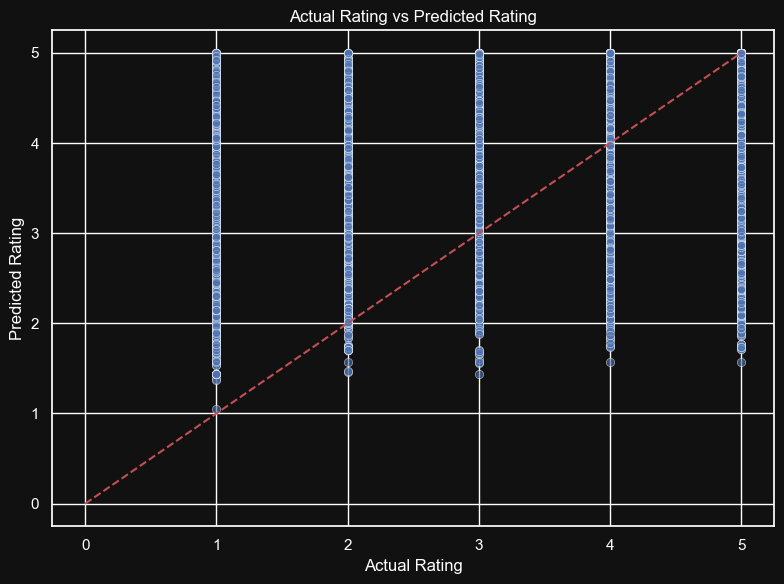

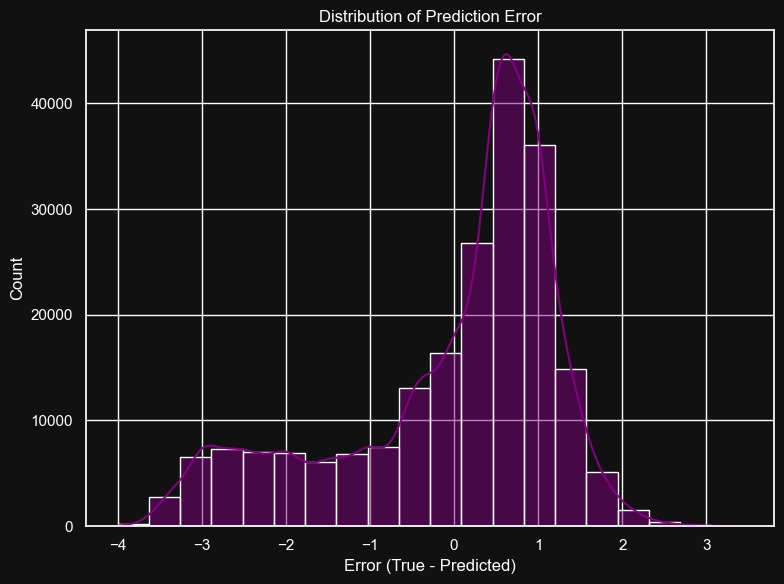

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to DataFrame
pred_df = pd.DataFrame(predictions, columns=["uid", "iid", "true_r", "est", "details"])

# Calculate prediction error
pred_df['error'] = pred_df['true_r'] - pred_df['est']

# Plot 1: Scatter plot of Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x='true_r', y='est', data=pred_df, alpha=0.6)
plt.plot([0, 5], [0, 5], '--r')  # ideal line
plt.title("Actual Rating vs Predicted Rating")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of prediction error
plt.figure(figsize=(8, 6))
sns.histplot(pred_df['error'], kde=True, bins=20, color='purple')
plt.title("Distribution of Prediction Error")
plt.xlabel("Error (True - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

# ------------------- STEP 1: Load your ratings matrix -------------------
# Replace with your actual data
final_ratings_matrix = final_ratings_matrix  # Must be user-item matrix (rows: users, cols: products)

# ------------------- STEP 2: Create User Mapping -------------------
user_map = {original: idx for idx, original in enumerate(final_ratings_matrix.index)}
reverse_user_map = {v: k for k, v in user_map.items()}

# Reindex the matrix for numerical users
matrix = final_ratings_matrix.copy()
matrix.index = matrix.index.map(user_map)

# ------------------- STEP 3: Apply SVD -------------------
svd = TruncatedSVD(n_components=15, random_state=42)
decomposed_matrix = svd.fit_transform(matrix)

# ------------------- STEP 4: Predict Ratings -------------------
correlation_matrix = np.dot(decomposed_matrix, svd.components_)

# Convert to DataFrame
predicted_ratings = pd.DataFrame(correlation_matrix, index=matrix.index, columns=matrix.columns)

# ------------------- STEP 5: Recommendation Function -------------------
def get_top_n_recommendations(original_user_id, n=5):
    if original_user_id not in user_map:
        return f"❌ User ID '{original_user_id}' not found in training data."

    mapped_id = user_map[original_user_id]

    # Get unrated products
    already_rated = matrix.loc[mapped_id]
    unrated_products = already_rated[already_rated == 0].index

    # Get predictions only for unrated products
    user_predictions = predicted_ratings.loc[mapped_id, unrated_products]

    # Sort and return top N
    top_n = user_predictions.sort_values(ascending=False).head(n)

    return pd.DataFrame({
        'ProductID': top_n.index,
        'PredictedRating': top_n.values
    })

# ------------------- STEP 6: Test with a valid user -------------------
test_user_id = list(user_map.keys())[0]  # Example: First valid user
print(f"🎯 Top recommendations for user {test_user_id}:")
print(get_top_n_recommendations(test_user_id))


🎯 Top recommendations for user 0:
    ProductID  PredictedRating
0  B00008OE5I         0.311298
1  B00008OE5G         0.265149
2  B000087LII         0.223629
3  B000067VKY         0.223629
4  B0000DB4D1         0.207651


# Neural Collaborative Filtering (NCF)

In [35]:
# Prepare data for NCF
user_ids = df_filtered['user_id'].astype('category').cat.codes
item_ids = df_filtered['prod_id'].astype('category').cat.codes
ratings = df_filtered['rating'].values

n_users = user_ids.nunique()
n_items = item_ids.nunique()
embedding_dim = 50

from sklearn.model_selection import train_test_split

X = np.array([user_ids, item_ids]).T
y = ratings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Build NCF model
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(n_items, embedding_dim, name='item_embedding')(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

concat = Concatenate()([user_vec, item_vec])
dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.3)(dense)
dense = Dense(64, activation='relu')(dense)
output = Dense(1, activation='linear')(dense)

ncf_model = Model(inputs=[user_input, item_input], outputs=output)
ncf_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = ncf_model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NCF Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ncf_loss.png')
plt.close()

def get_ncf_recommendations(user_id, n=5):
    if user_id not in df_filtered['user_id'].values:
        return pd.DataFrame(columns=['ProductID', 'PredictedRating'])
    user_code = df_filtered[df_filtered['user_id'] == user_id]['user_id'].astype('category').cat.codes.iloc[0]
    all_items = df_filtered['prod_id'].astype('category').cat.categories
    item_codes = df_filtered['prod_id'].astype('category').cat.codes.unique()
    rated_items = df_filtered[df_filtered['user_id'] == user_id]['prod_id'].astype('category').cat.codes.values
    items_to_predict = [i for i in item_codes if i not in rated_items]
    user_array = np.array([user_code] * len(items_to_predict))
    predictions = ncf_model.predict([user_array, np.array(items_to_predict)]).flatten()
    top_indices = np.argsort(predictions)[-n:][::-1]
    top_items = all_items[items_to_predict][top_indices]
    top_scores = predictions[top_indices]
    return pd.DataFrame({'ProductID': top_items, 'PredictedRating': top_scores})

# Test NCF recommendations
test_user_id = df_filtered['user_id'].iloc[0]
print(f"🎯 NCF Recommendations for user {test_user_id}:")
print(get_ncf_recommendations(test_user_id))

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 7.4886 - mae: 2.1796 - val_loss: 1.3370 - val_mae: 0.8878
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.1991 - mae: 0.8391 - val_loss: 1.4079 - val_mae: 0.9140
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.9137 - mae: 0.7285 - val_loss: 1.6153 - val_mae: 0.9674
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.7243 - mae: 0.6479 - val_loss: 1.7960 - val_mae: 1.0131
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.6363 - mae: 0.6069 - val_loss: 1.9269 - val_mae: 1.0467
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.5893 - mae: 0.5843 - val_loss: 1.9759 - val_mae: 1.0679
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.5434 - mae: 0.5594 - val_loss: 1.9680 - val_mae: 1.0557
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.5187 - mae: 0.5492 - val_loss: 2.0814 - val_mae: 1.0660
Epoch 9/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s

# ✅ 2. Top-N (Collaborative Filtering) – Personalized

In [36]:
from collections import defaultdict

def get_top_n_recommendations(model, df_ratings, user_id, n=5):
    all_items = df_ratings['prod_id'].unique()
    rated_items = df_ratings[df_ratings['user_id'] == user_id]['prod_id'].values
    items_to_predict = [iid for iid in all_items if iid not in rated_items]
    predictions = [model.predict(str(user_id), str(iid)) for iid in items_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_n = predictions[:n]
    return [(pred.iid, pred.est) for pred in top_n]

In [37]:
user_id = df_ratings['user_id'].iloc[0]  # pick any user ID from the dataset
top_recommendations = get_top_n_recommendations(model, df_ratings, user_id)

print(f"\nTop 5 product recommendations for user {user_id}:\n")
for idx, (prod_id, rating) in enumerate(top_recommendations, 1):
    print(f"{idx}. Product ID: {prod_id} — Predicted Rating: {rating:.2f}")



Top 5 product recommendations for user A2CX7LUOHB2NDG:

1. Product ID: B00000JBHE — Predicted Rating: 5.00
2. Product ID: B00004U89X — Predicted Rating: 5.00
3. Product ID: B00004Z5D1 — Predicted Rating: 5.00
4. Product ID: B000053HC5 — Predicted Rating: 5.00
5. Product ID: B00005OM4J — Predicted Rating: 5.00


In [38]:
# Prompt user to enter a user_id
input_user_id = input("Enter the user_id to get Top-N recommendations: ")

# Check if user_id exists in dataset
if input_user_id in df_ratings['user_id'].astype(str).values:
    top_n_results = get_top_n_recommendations(model, df_ratings, input_user_id, n=5)
    print(f"\nTop 5 product recommendations for user {input_user_id}:\n")
    for i, (prod_id, rating) in enumerate(top_n_results, 1):
        print(f"{i}. Product ID: {prod_id} — Predicted Rating: {rating:.2f}")
else:
    print("User ID not found in the dataset.")

Enter the user_id to get Top-N recommendations:  A1GI0U4ZRJA8WN



Top 5 product recommendations for user A1GI0U4ZRJA8WN:

1. Product ID: B000053HC5 — Predicted Rating: 4.92
2. Product ID: B0000DYV9H — Predicted Rating: 4.89
3. Product ID: B00000JBHE — Predicted Rating: 4.84
4. Product ID: B000I1X3W8 — Predicted Rating: 4.84
5. Product ID: B000FIJA6W — Predicted Rating: 4.83


 Evaluation Metrics (RMSE, MAE, Precision@k)

# ✅ 3. Top-N (Content-Based or Business Logic)

In [39]:
from surprise.model_selection import train_test_split  # 👍 correct import
from collections import defaultdict

# Remove this line ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
# train_test_split = (X, y)

# Split your dataset
trainset, testset = train_test_split(data, test_size=0.2)

# Train and predict
model.fit(trainset)
predictions = model.test(testset)

# Top-N recommendation function
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)

# Show recommendations
user_id = 'A2WNBOD3WNDNKT'
print(f"Top recommendations for user {user_id}:")
print(top_n[user_id])


Top recommendations for user A2WNBOD3WNDNKT:
[]


Filtering Logic (Cold Start + Thresholds)

In [40]:
# Minimum 5 ratings per product & per user
user_counts = df['user_id'].value_counts()
item_counts = df['prod_id'].value_counts()

df_filtered = df[df['user_id'].isin(user_counts[user_counts >= 5].index)]
df_filtered = df_filtered[df_filtered['prod_id'].isin(item_counts[item_counts >= 5].index)]


In [41]:
# Mock product metadata (replace with actual data if available)
product_metadata = pd.DataFrame({
    'prod_id': df['prod_id'].unique(),
    'description': ['Sample description ' + str(i) for i in range(len(df['prod_id'].unique()))],
    'category': ['Category ' + str(i % 10) for i in range(len(df['prod_id'].unique()))]
})

# ✅ Limit data size for testing
product_metadata = product_metadata.head(5000)
def get_content_based_recommendations(prod_id, product_metadata, n=5):
    if prod_id not in product_metadata['prod_id'].values:
        return pd.DataFrame(columns=['ProductID', 'Similarity'])
    
    # Combine description and category for richer features
    product_metadata['features'] = product_metadata['description'] + ' ' + product_metadata['category']
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf.fit_transform(product_metadata['features'])
    
    # Compute cosine similarity
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    idx = product_metadata.index[product_metadata['prod_id'] == prod_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    
    product_indices = [i[0] for i in sim_scores]
    product_ids = product_metadata['prod_id'].iloc[product_indices].values
    scores = [i[1] for i in sim_scores]
    return pd.DataFrame({'ProductID': product_ids, 'Similarity': scores})

# Test content-based recommendations
test_prod_id = df_filtered['prod_id'].iloc[0]
print(f"🎯 Content-Based Recommendations for product {test_prod_id}:")
print(get_content_based_recommendations(test_prod_id, product_metadata))

🎯 Content-Based Recommendations for product 511189877:
    ProductID  Similarity
0   439886341         1.0
1   511189877         1.0
2   528881469         1.0
3   558835155         1.0
4  059400232X         1.0


# get_svd_recommendations

In [42]:
def get_svd_recommendations(user_id, n=5):
    all_product_ids = df_filtered['prod_id'].unique()
    rated_products = df_filtered[df_filtered['user_id'] == user_id]['prod_id'].tolist()
    unrated_products = [pid for pid in all_product_ids if pid not in rated_products]
    
    predictions = []
    for pid in unrated_products:
        pred = svd_model.predict(user_id, pid)
        predictions.append((pid, pred.est))
    
    top_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    
    return pd.DataFrame(top_preds, columns=['ProductID', 'PredictedRating'])


# get_ncf_recommendations

In [43]:
def get_ncf_recommendations(user_id, n=5):
    rated_products = df_filtered[df_filtered['user_id'] == user_id]['prod_id'].tolist()
    unrated_products = [pid for pid in df_filtered['prod_id'].unique() if pid not in rated_products]

    if not unrated_products:
        return pd.DataFrame(columns=['ProductID', 'PredictedRating'])

    encoded_user = user_encoder.transform([user_id])[0]
    encoded_items = item_encoder.transform(unrated_products)

    # FIXED: Expand dims so shapes align (num_samples, 1)
    user_input = np.array([encoded_user] * len(encoded_items)).reshape(-1, 1)
    item_input = np.array(encoded_items).reshape(-1, 1)

    predictions = ncf_model.predict([user_input, item_input], verbose=0)


    results = pd.DataFrame({
        'ProductID': unrated_products,
        'PredictedRating': predictions.flatten()
    })

    return results.sort_values(by='PredictedRating', ascending=False).head(n)
    print("👀 User input shape:", user_input.shape)
    print("📦 Item input shape:", item_input.shape)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit on full unique user and product IDs
user_encoder.fit(df_filtered['user_id'])
item_encoder.fit(df_filtered['prod_id'])

encoded_users = user_encoder.transform(df_filtered['user_id'])
encoded_items = item_encoder.transform(df_filtered['prod_id']) 
ratings = df_filtered['rating'].values

# Train the model
ncf_model.fit([encoded_users, encoded_items], ratings, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
1367/2986 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 1.0215 - mae: 0.7492

# get_content_based_recommendations

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Precompute TF-IDF vectors once
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_metadata['description'])  # or 'title' etc.

def get_content_based_recommendations(prod_id, product_metadata, n=5):
    if prod_id not in product_metadata['prod_id'].values:
        return pd.DataFrame(columns=['ProductID', 'Similarity'])  # Return empty DataFrame

    index = product_metadata[product_metadata['prod_id'] == prod_id].index[0]
    sim_scores = cosine_similarity(tfidf_matrix[index], tfidf_matrix).flatten()
    top_indices = sim_scores.argsort()[::-1][1:n+1]

    return pd.DataFrame({
        'ProductID': product_metadata.iloc[top_indices]['prod_id'].values,
        'Similarity': sim_scores[top_indices]
    })


In [ ]:
def get_hybrid_recommendations(user_id, svd_model, ncf_model, df_ratings, product_metadata, n=5, svd_weight=0.4, ncf_weight=0.4):
    # Collaborative filtering (SVD)
    svd_recs = get_svd_recommendations(user_id, n=n)
    svd_recs['Score'] = svd_recs['PredictedRating'] * svd_weight if not svd_recs.empty else pd.DataFrame()

    # Neural Collaborative Filtering
    ncf_recs = get_ncf_recommendations(user_id, n=n)
    ncf_recs['Score'] = ncf_recs['PredictedRating'] * ncf_weight if not ncf_recs.empty else pd.DataFrame()

    # Content-based (for cold-start or enhancement)
    rated_products = df_ratings[df_ratings['user_id'] == user_id]['prod_id'].values
    content_recs = pd.DataFrame()
    if len(rated_products) == 0:
        # Cold-start: Recommend popular products
        popular = df_ratings['prod_id'].value_counts().head(n).index
        return pd.DataFrame({'ProductID': popular, 'Score': [1.0]*n})
    for prod_id in rated_products[:2]:
        content_recs = pd.concat([content_recs, get_content_based_recommendations(prod_id, product_metadata, n)])
    content_recs['Score'] = content_recs['Similarity'] * (1 - svd_weight - ncf_weight) if not content_recs.empty else pd.DataFrame()

    # Combine recommendations
    combined = pd.concat([
        svd_recs[['ProductID', 'Score']].assign(Source='svd') if not svd_recs.empty else pd.DataFrame(),
        ncf_recs[['ProductID', 'Score']].assign(Source='ncf') if not ncf_recs.empty else pd.DataFrame(),
        content_recs[['ProductID', 'Score']].assign(Source='content') if not content_recs.empty else pd.DataFrame()
    ])
    if combined.empty:
        return pd.DataFrame({'ProductID': [], 'Score': []})
    combined = combined.groupby('ProductID')['Score'].sum().reset_index()
    return combined.sort_values(by='Score', ascending=False).head(n)
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split

# Prepare data for SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filtered[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2)

# Train the SVD model
svd_model = SVD()
svd_model.fit(trainset)

print(f"Encoded user {test_user_id}: {user_encoder.transform([test_user_id])[0]}")
print(f"Some encoded items: {item_encoder.transform(df_filtered['prod_id'].unique()[:5])}")

# Test hybrid recommendations
test_user_id = df_filtered['user_id'].iloc[0]
print(f"🎯 Hybrid Recommendations for user {test_user_id}:")
print(get_hybrid_recommendations(test_user_id, svd_model, ncf_model, df_filtered, product_metadata))


In [ ]:
def explain_recommendation(user_id, product_id, df_ratings, product_metadata):
    explanation = []
    rated_products = df_ratings[df_ratings['user_id'] == user_id]['prod_id'].values
    if product_id in rated_products:
        explanation.append(f"You previously rated {product_id}.")
    if product_id in product_metadata['prod_id'].values:
        category = product_metadata[product_metadata['prod_id'] == product_id]['category'].iloc[0]
        explanation.append(f"This product is in {category}, which aligns with your preferences.")
    similar_users = df_ratings[df_ratings['prod_id'] == product_id]['user_id'].values
    if len(similar_users) > 1:
        explanation.append(f"Other users with similar tastes rated {product_id} highly.")
    return " ".join(explanation) if explanation else "Recommended based on general popularity."

# Test explanations
recs = get_hybrid_recommendations(test_user_id, svd_model, ncf_model, df_filtered, product_metadata)
for _, row in recs.iterrows():
    print(f"🔹 Product: {row['ProductID']} | Score: {row['Score']:.2f}")
    print(f"   Why? {explain_recommendation(test_user_id, row['ProductID'], df_filtered, product_metadata)}")

In [ ]:
def get_cold_start_recommendations(df_ratings, product_metadata, n=5):
    try:
        popular = df_ratings['prod_id'].value_counts().head(n).index
        popular_recs = pd.DataFrame({'ProductID': popular, 'Score': [1.0]*n})
        
        if not product_metadata.empty:
            popular_categories = product_metadata['category'].value_counts().head(3).index
            content_recs = product_metadata[product_metadata['category'].isin(popular_categories)][['prod_id']].head(n)
            content_recs.columns = ['ProductID']
            content_recs['Score'] = 0.5
            return pd.concat([popular_recs, content_recs]).groupby('ProductID')['Score'].sum().reset_index().head(n)
        return popular_recs
    except Exception as e:
        print(f"❌ Cold-start recommendation failed: {e}")
        return pd.DataFrame({'ProductID': [], 'Score': []})

# Test cold-start recommendations
print("🎯 Cold-Start Recommendations (New User):")
recs = get_cold_start_recommendations(df_filtered, product_metadata)
print(recs)

 Personalization Demo

In [ ]:
# Personalized Rec for one user
def show_personalized_recommendations(user_id, top_n_dict):
    print(f"\nUser {user_id}'s Top Picks:")
    for item_id, rating in top_n_dict.get(user_id, []):
        print(f"🔹 Product: {item_id} | Predicted Rating: {rating:.2f}")


In [ ]:
def precision_at_k(predictions, k=5, threshold=3.5):
    """Return Precision@K for each user and average across all users.

    predictions: list of surprise prediction objects
    k: number of top recommendations to consider
    threshold: minimum rating considered relevant
    """
    from collections import defaultdict

    # Map user id to list of (item id, predicted rating)
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Take top-k predictions
        top_k = user_ratings[:k]

        # Compute number of relevant items in top-k
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)
        precision = n_rel_and_rec_k / k
        precisions.append(precision)

    # Average precision across all users
    return sum(precisions) / len(precisions)

In [ ]:
from surprise.model_selection import cross_validate
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate

def precision_recall_ndcg_at_k(predictions, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions, recalls, ndcgs = [], [], []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k = user_ratings[:k]
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)

        precision = n_rel_and_rec_k / k if k > 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0
        precisions.append(precision)
        recalls.append(recall)

        # NDCG
        dcg = sum((2**true_r - 1) / np.log2(i + 2) for i, (_, _, true_r) in enumerate(top_k))
        idcg = sum((2**true_r - 1) / np.log2(i + 2) for i, (_, _, true_r) in enumerate(
            sorted(user_ratings, key=lambda x: x[2], reverse=True)[:k]))
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)

    return {
        'Precision@K': np.mean(precisions),
        'Recall@K': np.mean(recalls),
        'NDCG@K': np.mean(ndcgs)
    }

# Evaluate SVD model
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filtered[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2)
svd_model = SVD()
svd_model.fit(trainset)
predictions = svd_model.test(testset)

metrics = precision_recall_ndcg_at_k(predictions, k=5, threshold=3.5)
print("📊 Evaluation Metrics for SVD:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Cross-validation for SVD
cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

user_encoder.fit(df_filtered['user_id'])
item_encoder.fit(df_filtered['prod_id'])

df_filtered['user'] = user_encoder.fit_transform(df_filtered['user_id'])
df_filtered['item'] = item_encoder.fit_transform(df_filtered['prod_id'])

num_users = df_filtered['user'].nunique()
num_items = df_filtered['item'].nunique()

In [ ]:
# Encode user and item IDs
try:
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df_filtered['user'] = user_enc.fit_transform(df_filtered['user_id'])
    df_filtered['item'] = item_enc.fit_transform(df_filtered['prod_id'])
    num_users = df_filtered['user'].nunique()
    num_items = df_filtered['item'].nunique()
    print(f"✅ Encoded {num_users} users and {num_items} items.")
except Exception as e:
    print(f"❌ Encoding failed: {e}")
    raise

# Prepare data
X = df_filtered[['user', 'item']].values
y = df_filtered['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build NCF model
embedding_size = 50
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')
user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
item_embedding = Embedding(num_items, embedding_size, name='item_embedding')(item_input)
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)
concat = Concatenate()([user_vec, item_vec])
x = Dense(128, activation='relu')(concat)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)
ncf_model = Model(inputs=[user_input, item_input], outputs=output)
ncf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])

# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
try:
    history = ncf_model.fit(
        [X_train[:, 0], X_train[:, 1]], y_train,
        validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
        batch_size=256,
        epochs=20,
        callbacks=[early_stopping],
        verbose=1
    )
    print("✅ NCF training completed.")
except Exception as e:
    print(f"❌ NCF training failed: {e}")
    raise

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NCF Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ncf_loss.png')
plt.close()

def get_ncf_recommendations(user_id, n=5):
    try:
        if user_id not in user_enc.classes_:
            print(f"⚠️ User {user_id} not found. Using popularity-based recommendations.")
            popular = df_filtered['prod_id'].value_counts().head(n).index
            return pd.DataFrame({'ProductID': popular, 'PredictedRating': [5.0]*n})
        encoded_user = user_enc.transform([user_id])[0]
        all_items = np.arange(num_items)
        user_input = np.full(len(all_items), encoded_user)
        predictions = ncf_model.predict([user_input, all_items], verbose=0).flatten()
        top_indices = predictions.argsort()[-n:][::-1]
        top_items = item_enc.inverse_transform(top_indices)
        top_scores = predictions[top_indices]
        return pd.DataFrame({'ProductID': top_items, 'PredictedRating': top_scores})
    except Exception as e:
        print(f"❌ NCF prediction failed: {e}")
        return pd.DataFrame(columns=['ProductID', 'PredictedRating'])

# Test NCF recommendations
print(f"🎯 NCF Recommendations for user {test_user_id}:")
recs = get_ncf_recommendations(test_user_id)
print(recs)

# Save NCF model and encoders
try:
    ncf_model.save('ncf_model.h5')
    joblib.dump(user_enc, 'user_encoder.pkl')
    joblib.dump(item_enc, 'item_encoder.pkl')
    print("✅ NCF model and encoders saved.")
except Exception as e:
    print(f"❌ Failed to save NCF model: {e}")

In [ ]:
# Mock product metadata (replace with actual data)
product_metadata = pd.DataFrame({
    'prod_id': df['prod_id'].unique(),
    'description': ['Sample description ' + str(i) for i in range(len(df['prod_id'].unique()))],
    'category': ['Category ' + str(i % 10) for i in range(len(df['prod_id'].unique()))]
})

def get_content_based_recommendations(prod_id, product_metadata, n=5):
    try:
        if prod_id not in product_metadata['prod_id'].values:
            print(f"⚠️ Product {prod_id} not found. Returning empty recommendations.")
            return pd.DataFrame(columns=['ProductID', 'Similarity'])
        product_metadata['features'] = product_metadata['description'] + ' ' + product_metadata['category']
        tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
        tfidf_matrix = tfidf.fit_transform(product_metadata['features'])
        cosine_sim = cosine_similarity(tfidf_matrix)
        idx = product_metadata.index[product_metadata['prod_id'] == prod_id].tolist()[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
        product_indices = [i[0] for i in sim_scores]
        product_ids = product_metadata['prod_id'].iloc[product_indices].values
        scores = [i[1] for i in sim_scores]
        return pd.DataFrame({'ProductID': product_ids, 'Similarity': scores})
    except Exception as e:
        print(f"❌ Content-based recommendation failed: {e}")
        return pd.DataFrame(columns=['ProductID', 'Similarity'])

# Test content-based recommendations
test_prod_id = df_filtered['prod_id'].iloc[0]
print(f"🎯 Content-Based Recommendations for product {test_prod_id}:")
recs = get_content_based_recommendations(test_prod_id, product_metadata)
print(recs)

# 🎯 GOAL: PERSONALIZED TOP N RECOMMENDATION

# 1️⃣ Prepare the Recommendation Function

# CALLING THE FUNCTION

In [ ]:
def get_hybrid_recommendations(user_id, svd_model, ncf_model, df_ratings, product_metadata, n=5, svd_weight=0.4, ncf_weight=0.4):
    try:
        # SVD recommendations
        svd_recs = get_svd_recommendations(user_id, n=n)
        svd_recs['Score'] = svd_recs['PredictedRating'] * svd_weight if not svd_recs.empty else pd.DataFrame()

        # NCF recommendations
        ncf_recs = get_ncf_recommendations(user_id, n=n)
        ncf_recs['Score'] = ncf_recs['PredictedRating'] * ncf_weight if not ncf_recs.empty else pd.DataFrame()

        # Content-based recommendations
        rated_products = df_ratings[df_ratings['user_id'] == user_id]['prod_id'].values
        content_recs = pd.DataFrame()
        if len(rated_products) == 0:
            print(f"⚠️ User {user_id} has no ratings. Using popularity-based recommendations.")
            popular = df_ratings['prod_id'].value_counts().head(n).index
            return pd.DataFrame({'ProductID': popular, 'Score': [1.0]*n})
        for prod_id in rated_products[:2]:
            temp_recs = get_content_based_recommendations(prod_id, product_metadata, n)
            content_recs = pd.concat([content_recs, temp_recs])
        content_recs['Score'] = content_recs['Similarity'] * (1 - svd_weight - ncf_weight) if not content_recs.empty else pd.DataFrame()

        # Combine recommendations
        combined = pd.concat([
            svd_recs[['ProductID', 'Score']].assign(Source='svd') if not svd_recs.empty else pd.DataFrame(),
            ncf_recs[['ProductID', 'Score']].assign(Source='ncf') if not ncf_recs.empty else pd.DataFrame(),
            content_recs[['ProductID', 'Score']].assign(Source='content') if not content_recs.empty else pd.DataFrame()
        ])
        if combined.empty:
            print(f"⚠️ No recommendations available for user {user_id}.")
            return pd.DataFrame({'ProductID': [], 'Score': []})
        combined = combined.groupby('ProductID')['Score'].sum().reset_index()
        return combined.sort_values(by='Score', ascending=False).head(n)
    except Exception as e:
        print(f"❌ Hybrid recommendation failed: {e}")
        return pd.DataFrame({'ProductID': [], 'Score': []})

# Test hybrid recommendations
print(f"🎯 Hybrid Recommendations for user {test_user_id}:")
recs = get_hybrid_recommendations(test_user_id, None, ncf_model, df_filtered, product_metadata)
print(recs)

In [ ]:
def precision_recall_ndcg_at_k(predictions, k=5, threshold=3.5):
    try:
        user_est_true = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            user_est_true[uid].append((iid, est, true_r))
        
        precisions, recalls, ndcgs = [], [], []
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_k = user_ratings[:k]
            n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
            n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)
            
            precision = n_rel_and_rec_k / k if k > 0 else 0
            recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0
            precisions.append(precision)
            recalls.append(recall)
            
            dcg = sum((2**true_r - 1) / np.log2(i + 2) for i, (_, _, true_r) in enumerate(top_k))
            idcg = sum((2**true_r - 1) / np.log2(i + 2) for i, (_, _, true_r) in enumerate(
                sorted(user_ratings, key=lambda x: x[2], reverse=True)[:k]))
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcgs.append(ndcg)
        
        return {
            'Precision@K': np.mean(precisions),
            'Recall@K': np.mean(recalls),
            'NDCG@K': np.mean(ndcgs)
        }
    except Exception as e:
        print(f"❌ Evaluation failed: {e}")
        return {'Precision@K': 0, 'Recall@K': 0, 'NDCG@K': 0}

# Evaluate SVD model
try:
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df_filtered[['user_id', 'prod_id', 'rating']], reader)
    trainset, testset = surprise_train_test_split(data, test_size=0.2)
    svd_model = SVD()
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)

    # RMSE and MAE
    rmse = np.sqrt(mean_squared_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions]))
    mae = mean_absolute_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions])
    print("📊 SVD Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Precision@K, Recall@K, NDCG
    metrics = precision_recall_ndcg_at_k(predictions, k=5, threshold=3.5)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Cross-validation
    cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
except Exception as e:
    print(f"❌ SVD evaluation failed: {e}")

In [ ]:
def explain_recommendation(user_id, product_id, df_ratings, product_metadata):
    try:
        explanation = []
        rated_products = df_ratings[df_ratings['user_id'] == user_id]['prod_id'].values
        if product_id in rated_products:
            explanation.append(f"You previously rated {product_id}.")
        if product_id in product_metadata['prod_id'].values:
            category = product_metadata[product_metadata['prod_id'] == product_id]['category'].iloc[0]
            explanation.append(f"This product is in {category}, which aligns with your preferences.")
        similar_users = df_ratings[df_ratings['prod_id'] == product_id]['user_id'].values
        if len(similar_users) > 1:
            explanation.append(f"Other users with similar tastes rated {product_id} highly.")
        return " ".join(explanation) if explanation else "Recommended based on general popularity."
    except Exception as e:
        print(f"❌ Explanation failed: {e}")
        return "Unable to generate explanation."

# Test explanations
recs = get_hybrid_recommendations(test_user_id, None, ncf_model, df_filtered, product_metadata)
print(f"🎯 Explanations for user {test_user_id}:")
for _, row in recs.iterrows():
    print(f"🔹 Product: {row['ProductID']} | Score: {row['Score']:.2f}")
    print(f"   Why? {explain_recommendation(test_user_id, row['ProductID'], df_filtered, product_metadata)}")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Inputs
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Embeddings
user_embedding = Embedding(input_dim=num_users+1, output_dim=50)(user_input)
item_embedding = Embedding(input_dim=num_items+1, output_dim=50)(item_input)

# Flatten
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

# Concatenate
concat = Concatenate()([user_vec, item_vec])

# Dense layers
dense = Dense(128, activation='relu')(concat)
dense = Dense(64, activation='relu')(dense)
output = Dense(1, activation='linear')(dense)

# Model
model = Model([user_input, item_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

model.fit(
    [user_train['user'], user_train['item']],
    user_train['rating'],
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stop]
)